In [1]:
from discover_lora_vae.models import LoraVAE
import diffusers
import torch
from tqdm import tqdm 
from common.utils import make_weight_vector, recover_lora, convert_to_multi
from PIL import Image
import matplotlib.pyplot as plt

lora_vae = LoraVAE(
    data_dim=1_365_504,
    model_dim=512,
    ff_mult=3.0,
    chunks=1,
    encoder_layers=20,
    decoder_layers=20
)

state_dict = torch.load('/home/ubuntu/AutoLoRADiscovery/discover_lora_vae/model-output/checkpoint-60000')
lora_vae.load_state_dict(state_dict)
lora_vae = lora_vae.cuda().to(torch.float16)

/home/ubuntu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lora_path = "/home/ubuntu/AutoLoRADiscovery/common/lora_outputs/lora-Mike Tyson/lora_layers_new.pth"
orig_state_dict = torch.load(lora_path, map_location='cpu')

In [3]:
orig_state_dict = convert_to_multi(orig_state_dict, 0)

In [4]:
orig_lora_vec, weight_dict = make_weight_vector(orig_state_dict)
orig_lora_vec = (orig_lora_vec).unsqueeze(0).cuda().to(torch.float16)

In [5]:
import diffusers
from common.loras import patch_lora

pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.safety_checker=None

lora_layers = [
        "attn2.to_q", 
        "attn2.to_k", 
        "attn2.to_v", 
        "attn2.to_out",
        # "proj_in",
        # "proj_out",
        # "norm",
        #  "ff", 
]
lora_layers_te = [
    "final_layer_norm",
    "7",
    "8",
    "9",
    "10",
    "11"
]

patch_lora(pipe.unet, rank=8, included_terms=lora_layers)
patch_lora(pipe.text_encoder, rank=8, included_terms=lora_layers_te)


/home/ubuntu/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.39it/s]


In [6]:
missing, unexpected = pipe.unet.load_state_dict(orig_state_dict, strict=False)
missing, unexpected = pipe.text_encoder.load_state_dict(orig_state_dict, strict=False)
pipe = pipe.to("cuda", torch.float16)

: 

In [20]:
seed = 3
torch.manual_seed(seed)
images = pipe(["a photo of a sks person"]*4, height=640, width=640, num_inference_steps=30).images

orig_canvas = Image.new('RGB', (640*4, 640))
for i, image in enumerate(images):
    orig_canvas.paste(image, (640*i, 0))

100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


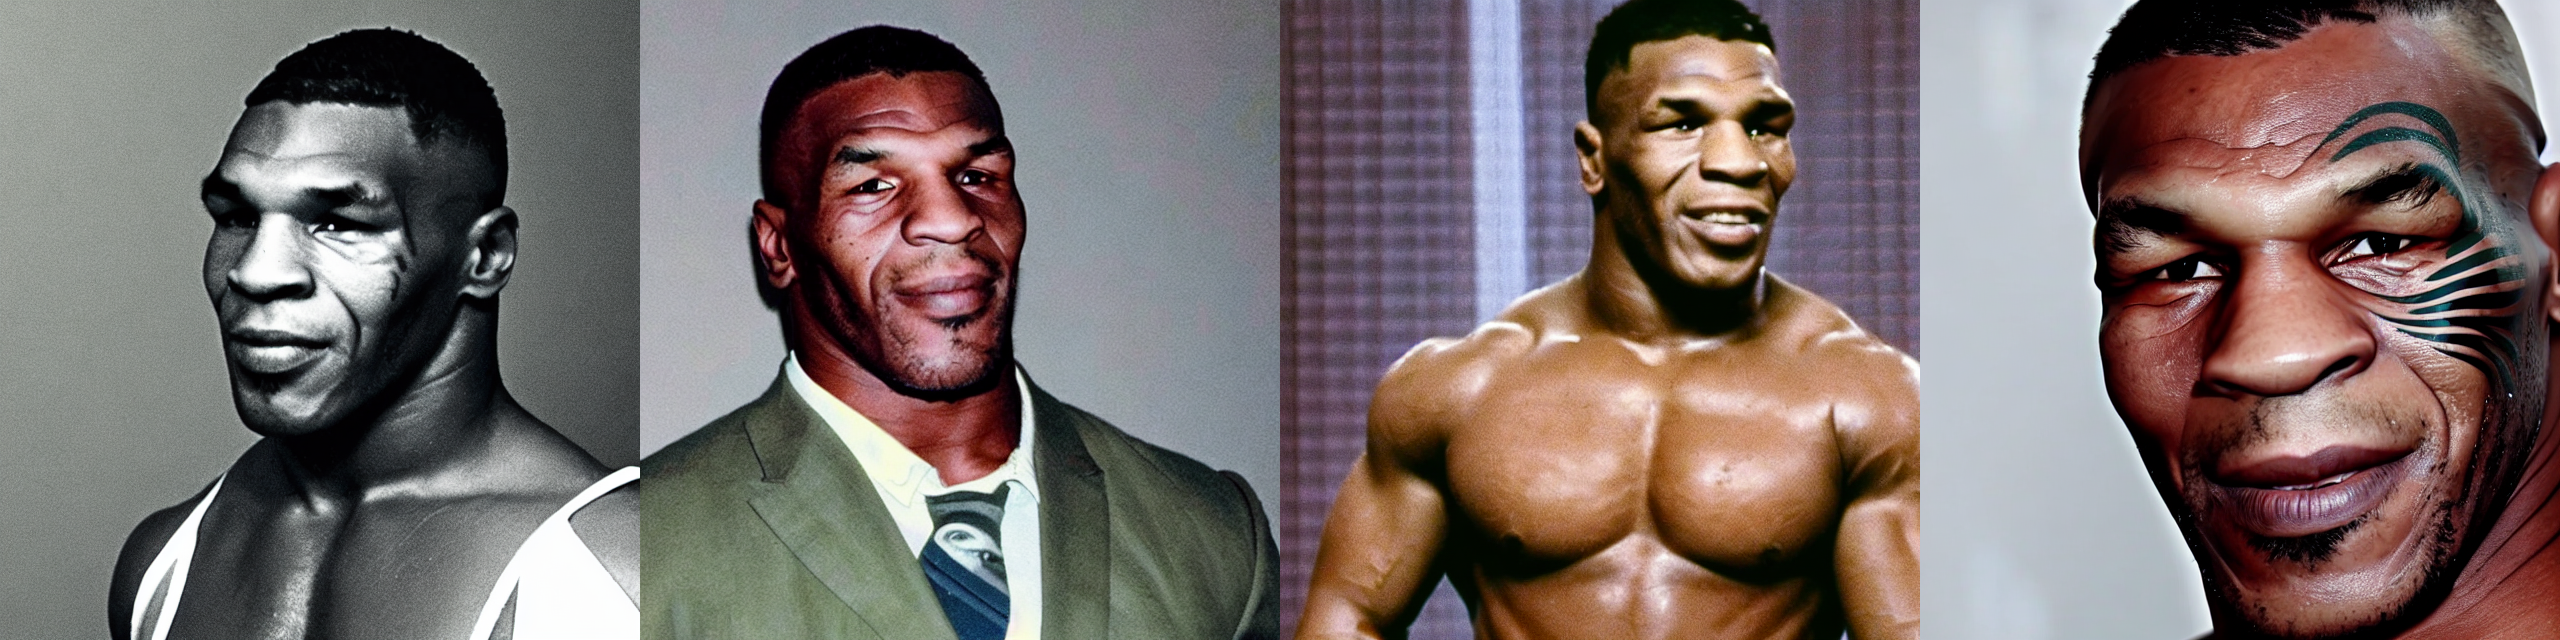

In [21]:
orig_canvas

In [7]:
num_times = 1 # higher numbers will further depart from the person
fac = 1.0

new_lora_vec = orig_lora_vec.clone() / 0.0152
for i in range(num_times):
    with torch.no_grad():
        mean, logvar = lora_vae.encoder(new_lora_vec)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std * fac
        new_lora_vec = lora_vae.decoder(z)

new_lora_vec = new_lora_vec * 0.0152

state_dict_new = recover_lora(new_lora_vec, weight_dict)
state_dict_new = convert_to_multi(state_dict_new, idx=0)

In [8]:
missing, unexpected = pipe.unet.load_state_dict(state_dict_new, strict=False)
missing, unexpected = pipe.text_encoder.load_state_dict(state_dict_new, strict=False)
pipe = pipe.to("cuda", torch.float16)

In [10]:
torch.manual_seed(seed)
images = pipe(["a photo of a sks person"]*4, height=640, width=640, num_inference_steps=30).images

100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


In [11]:
canvas = Image.new('RGB', (640*4, 640))
for i, image in enumerate(images):
    canvas.paste(image, (640*i, 0))

In [12]:
orig_canvas

NameError: name 'orig_canvas' is not defined

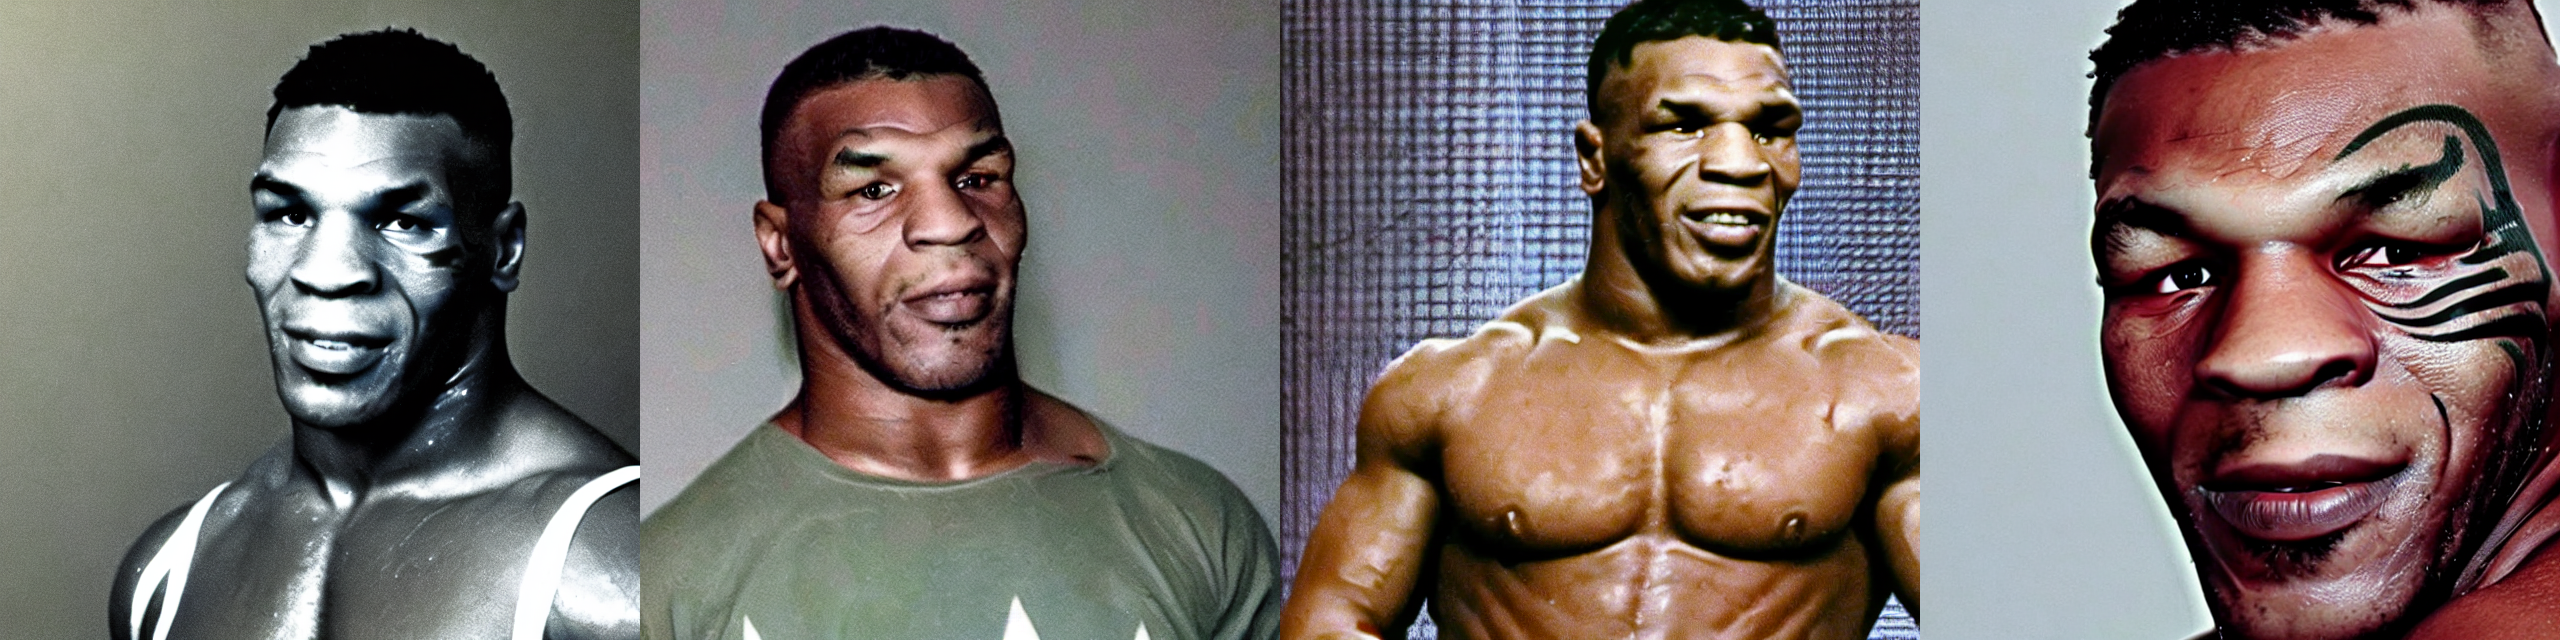

In [13]:
canvas